In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

# Overlay Mesh Graph on UK Map

In [3]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat + 0.1, city, transform=ccrs.PlateCarree())

def grid_points(ax, grid_xy):
    ax.plot(grid_xy[0], grid_xy[1], 'ro', transform=ccrs.PlateCarree(), markersize=1)

def mesh_points(ax, mesh_pos):
    ax.plot(mesh_pos[0], mesh_pos[1], 'go', transform=ccrs.PlateCarree(), markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=ccrs.PlateCarree(),
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set): 
    for edge in g2m_edge_set:
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=ccrs.PlateCarree(),
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=ccrs.PlateCarree(),
            linewidth=0.5
        )
        
def degrees(edge_index):
    degrees = [0] * (max(edge_index[0]) + 1)
    for i in range(edge_index.shape[1]):
        degrees[edge_index[0, i]] += 1
        
    return max(degrees), min(degrees)

In [4]:
# Load grid nodes
dir = "./data/era5_uk/static/nwp_xy.npy"
grid_xy = np.load(dir)
grid_xy = grid_xy.reshape(2, -1)


In [5]:
# Load mesh nodes
graph_name = "uk_graphcast"
graph_dir_path = os.path.join("graphs", graph_name)

# mesh_pos = np.load(os.path.join(graph_dir_path, "mesh_pos.npy"))
mesh_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt")).T
m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))[0]
edge_set = {tuple(sorted(e)) for e in m2m_edge_index.T}

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
g2m_edge_set = sorted(list({tuple(e) for e in g2m_edge_index.T}))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
m2g_edge_set = sorted(list({tuple(e) for e in m2g_edge_index.T}))

In [13]:
print("Verify g2m connectivity")
print("Grid Nodes min, max: ", g2m_edge_index[0].min(), g2m_edge_index[0].max())
print("Mesh nodes min, max: ", g2m_edge_index[1].min(), g2m_edge_index[1].max())
print("Grid Nodes unique:", g2m_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", g2m_edge_index[1].unique().shape[0])

Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(3704)
Mesh nodes min, max:  tensor(0) tensor(354)
Grid Nodes unique: 3705
Mesh nodes unique: 355


In [14]:
print("Verify m2g connectivity")
print("Grid Nodes min, max: ", m2g_edge_index[0].min(), m2g_edge_index[0].max())
print("Mesh nodes min, max: ", m2g_edge_index[1].min(), m2g_edge_index[1].max())
print("Grid Nodes unique:", m2g_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", m2g_edge_index[1].unique().shape[0])

Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(354)
Mesh nodes min, max:  tensor(0) tensor(3704)
Grid Nodes unique: 355
Mesh nodes unique: 3705


UK Bounding box:
[-12.0, 6.0, 45.0, 65.0]


Text(0.5, 1.0, 'ERA5 UK - GraphCast')

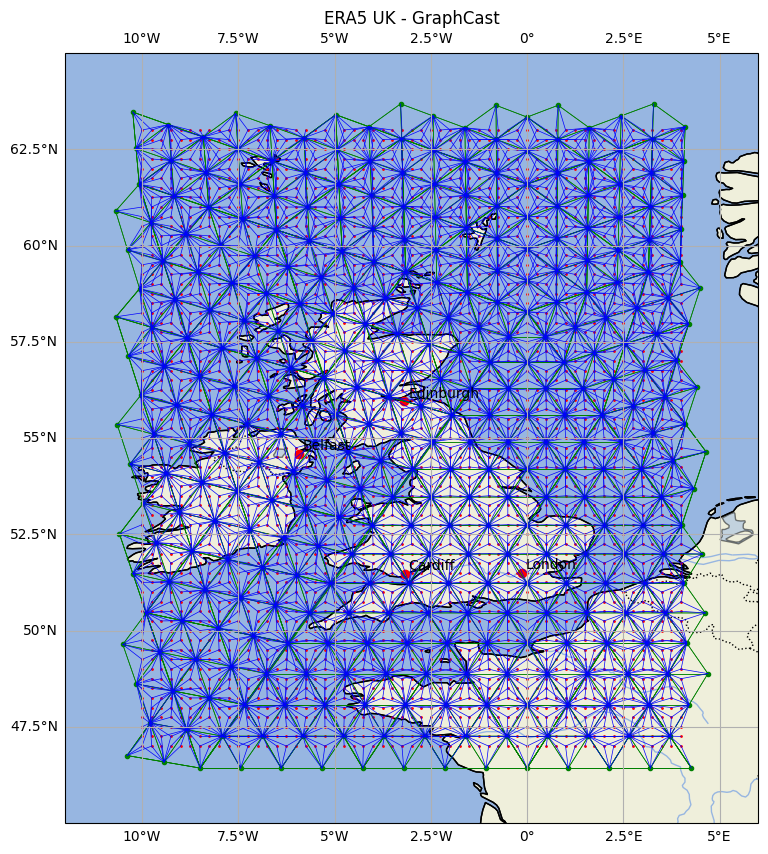

In [6]:
# Create a map with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to focus on the UK
lon, lat = grid_xy
uk_extent = [lon.min() - 2, lon.max() + 2, lat.min() - 2, lat.max() + 2]
ax.set_extent(uk_extent)
print("UK Bounding box:")
print(uk_extent)

# Add geographical features
add_geo_features(ax)

# Add cities
cities = {
    'London': (-0.1276, 51.5074),
    'Edinburgh': (-3.1883, 55.9533),
    'Cardiff': (-3.1791, 51.4816),
    'Belfast': (-5.9301, 54.5973)
}
add_cities(ax, cities)

# Add grid nodes
grid_points(ax, grid_xy)

# Add mesh nodes
mesh_points(ax, mesh_pos)

# Add m2m edges
m2m_edges(ax, mesh_pos, edge_set)

# Add g2m edges
g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set)

# Add m2g edges
# m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_lables = False
gl.right_labels = False

plt.title('ERA5 UK - GraphCast')